In [141]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
sx = qt.sigmax();sy = qt.sigmay(); sz = qt.sigmaz(); s0 = qt.qeye(2); sm = qt.sigmam(); sp = qt.sigmap()

### Getting signal from differential equation
The block below is design to solve differential equation corresponding to RLC circuit with a harmonic drive using a RK4 scheme:
$$
\frac{d^2 V}{d^2 t} = 
$$
where the resistance $R$ instead of being constant is modeled using sensor dot approch (see the next markdown).

In [142]:
class rlc_ode():
    def __init__(self, L, C, wd, drive_amplitude, noise, sensor_dot, dt = None, bit = 1, deps = 1):   
        self.L = L
        self.C = C
        self.wd = wd
        self.Ad = drive_amplitude
        self.dt = dt
        self.noise = noise
        self.bit = bit
        self.deps = deps
        self.sd = sensor_dot

    def fdx(self, x, t, xi, bit):
        R = self.sd.get_R(xi, bit)
        Vt = self.Ad*np.cos(self.wd*t)
        return np.array([x[1], -R/self.L*x[1] -x[0]/self.L/self.C + Vt/self.L/self.C ])

    def RK4_step(self, x, t):
        l1 = self.fdx(x, t, self.noise.get_x(),self.bit)
        self.noise.update(self.dt/2)
        l2 = self.fdx(x + l1 * self.dt / 2, t +self.dt/2,self.noise.get_x(),self.bit)
        l3 = self.fdx(x+ l2 * self.dt / 2, t+self.dt/2,self.noise.get_x(),self.bit)
        xi = self.noise.update(self.dt/2)
        l4 = self.fdx(x + l3 * self.dt, t,self.noise.get_x(), self.bit)
        return x + self.dt * (l1 + 2 * l2 + 2 * l3 + l4) / 6, t, xi

    def solve_ode(self, x0, times):
        di = np.zeros(len(times))
        i = np.zeros(len(times))
        xis = np.zeros(len(times))
        self.dt = times[1]-times[0]
        i[0] = x0[0]
        di[0] = x0[1]
        x = x0
        for n,t in enumerate(times[:-1]):
            x,t0, xi  = self.RK4_step(x, t)
            i[n+1] = x[0]
            di[n+1] = x[1]
            xis[n+1] = xi
        return i, di, xis

#### Model of the resistance
We model conductivity $G = 1/R$ of sensor dot using the equation:
$$
1/R(\epsilon) = G(\epsilon) = G_\text{max} \frac{\Delta E }{k_b T} \cosh\left(\frac{\epsilon + \epsilon_0}{2k_b T}\right)^{-2}
$$
and set $T = 100$ mK, $\Delta E = 1$ meV amd $G_\text{max} = 10^{-6}/\Omega$, such that typical $R \approx h/e^2 \approx 10k\Omega$

We set $\epsilon_0 = k_b T$ such that for $\epsilon = 0$ the $R(\epsilon) = 10 k\Omega$ (see figure below)

In [193]:
class sensor_dot():
    def __init__(self, dmu = 1, gmax = 1e-6, T=100, dE = 1e3):
        self.gmax = gmax
        self.T = T #mK
        self.dE = 1e3 #mueV
        self.kb = 0.08617 #mueV/mK
        self.eps0 = self.kb*self.T #mueV  #Shift such that for eps=0 we sit at the flank
        self.dmu = dmu #mueV shift in the dot chemical potential

    def get_R(self, xi, bit):
        eps = bit*self.dmu
        G = self.gmax*self.dE/self.kb/self.T*np.cosh((eps+xi+self.eps0)/2/self.kb/self.T)**(-2)
        return 1/G

Text(0.5, 0, 'Dot energy $\\epsilon$ [$\\mu$eV]')

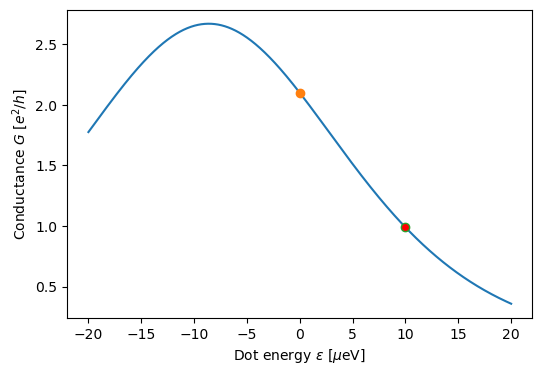

In [194]:
sd = sensor_dot(dmu = 10, gmax=1e-6, T=100, dE = 1e3)
eps = np.linspace(-20,20,1001)
plt.figure(figsize=(6,4))
plt.plot(eps,1/sd.get_R(eps,bit=0)*23*1e3)
plt.plot([0],[1/sd.get_R(0,bit=0)*23*1e3], "o")

deps = 2 #shift due to presence of the charge close to cherge sensor in $\mu$eV
plt.plot([sd.dmu],[1/sd.get_R(0,bit=1)*23*1e3], "o", mfc = "r")
plt.ylabel("Conductance $G$ [$e^2/h$]")
plt.xlabel("Dot energy $\epsilon$ [$\mu$eV]")

#### Model of the noise
We finaly add the time-correlated noise. The simples example of this would be Ornstein-Uhlenbeck process ([wiki](https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process)), that is characterized by its amplitude $\sigma$ and the correlation time $\tau_c$, and can be generated from difference equation:
$$
 \xi_{n+1} = \xi_n(1-\Delta t/\tau_c) +\sqrt{\frac{2 \sigma^2 \Delta t}{\tau_c}} \mathcal N(0,1)
$$
Or the more numerically stable version of it (see functions below).

The typical amplitude reads $\sigma = 10\mu eV$, while the correlation time is relatively long, which we set to $\tau_c = \mu s$

The noise enters the system by time-correlated shifts of the sensor dot, i.e.
$$
\epsilon(t) = \epsilon + \xi(t),
$$
which ultimately modifies the resistance of the sensor dot
$$
R(\epsilon(t))
$$




In [145]:
class OU_process():
    def __init__(self, sig, tc):
        self.x = sig*np.random.normal(0,1)
        self.sig = sig
        self.tc = tc
    
    def update(self, dt):
        n = np.random.normal(0,1)
        self.x = self.x*(np.exp(-dt/self.tc)) + +np.sqrt(1-np.exp(-2*dt/self.tc))*self.sig*n
        return self.x

    def get_x(self):
        return self.x

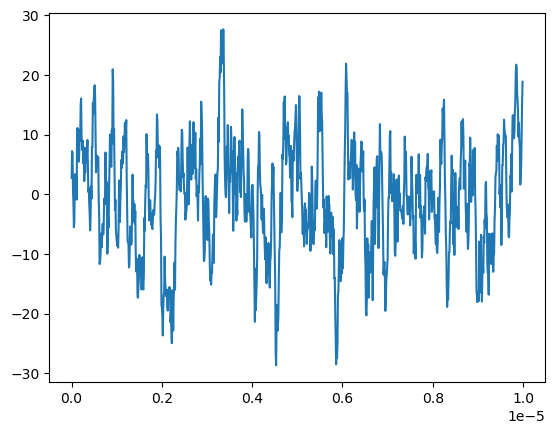

In [146]:
dt = 1e-8
N = int(1e3)
times = np.arange(0,N)*dt
noise = OU_process(sig = 10, tc = 1e-6)
plt.plot(times, [noise.update(1e-7) for i in range(N)])

##### Solution


In [249]:
#Parametesr
Lc = 800*1e-9  #H
Cp = 0.6*1e-12 #F
Rc = 10*1e6    #Ohm
Rl = 20        #Ohm
w = 1/np.sqrt(Lc*Cp) #Hz

noise = OU_process(sig = 1e1, tc =1e-7)
sd = sensor_dot(dmu = 1, gmax=1e-6, T=100, dE = 1e3)

In [250]:
rlc1 = rlc_ode(L=Lc, 
               C=Cp, 
               wd=1/np.sqrt(Lc*Cp), 
               drive_amplitude=1, 
               noise = noise, 
               sensor_dot=sd, 
               bit=1)


rlc0 = rlc_ode(L=Lc, 
               C=Cp, 
               wd=1/np.sqrt(Lc*Cp), 
               drive_amplitude=1, 
               noise = noise, 
               sensor_dot=sd, 
               bit=0)

times = np.linspace(0,1e-6,400001)
i1, di,xi1 = rlc1.solve_ode(x0 = [0,0], times = times)
i0, di,xi0 = rlc0.solve_ode(x0 = [0,0], times = times)



Text(0.5, 0, 'Time [s]')

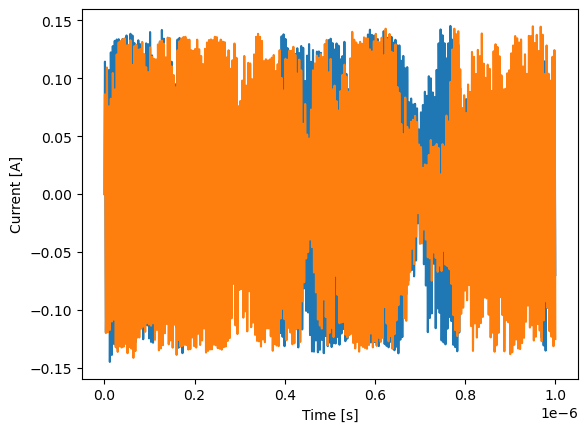

In [251]:
plt.plot(times,i1)
plt.plot(times,i0)
plt.ylabel("Current [A]")
plt.xlabel("Time [s]")

#### Low-pass filter
The final ingredient is the low-pass filter, which we realise by applying the moving average.

(0.0, 0.1)

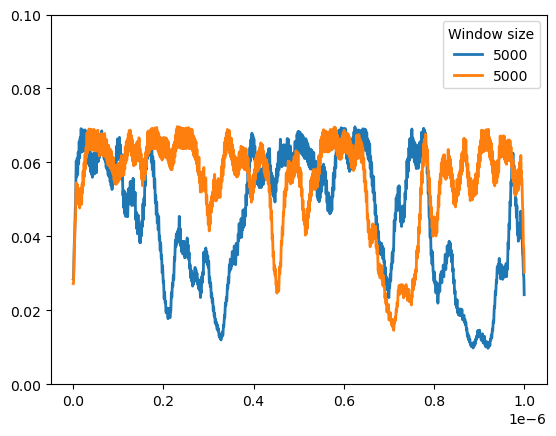

In [252]:
def lowpass(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='same')
    
def modulate(x, w):
    return x*np.sin(w*times)


colors = ["r","g"]



# apply moving average
N = 5000
s1 = lowpass(modulate(i1, w), N)
s0 = lowpass(modulate(i0, w), N)
plt.plot(times,s1, label = 5000, lw=2)
plt.plot(times,s0, label = 5000, lw=2)

plt.legend(title = "Window size")
#plt.xlim(right=5*1e-6)
plt.ylim(0,0.1)

#### Aprpoximate model
However the above solution is heavy, i.e. it takes a lot of time to simulate, and we need at least $10\mu s$ of signal. Thus we use the steady state solution of the RLC, mix it with the noise in R and compare against exact solution.

The steady state solution reads:
$$
I(t) = \frac{A}{\sqrt{(\omega L - \frac{1}{\omega C})^2 + R^2}}*\sin(\omega_d t + \delta), \qquad \delta = \arctan\left(\frac{1/\omega C - \omega L}{R}\right)
$$

At resonance $I(t)  = A\sin(\omega_d t) /R$.

We assume:
$
R = R(t) = R_\text{sensor-dot}(\epsilon + \xi(t))
$


In [ ]:
def RLC_solution(L, C, sd, times, noise, A=1,bit=1):
    w = np.sqrt(1/L/C)
    deps0 = 1
    dt = times[1]-times[0]
    xi =  np.array([noise.update(dt) for k in range(len(times))]) 
    R = sd.get_R(xi,bit)
    d = np.arctan((1/w/C-w*L)/R)
    return A/np.sqrt((w*L-1/w/C)**2+R**2)*np.sin(w*times+d)


def RLC_solution_tr(L, C, sd, times, trajcetory, A=1,bit=1):
    w = np.sqrt(1/L/C)
    dt = times[1]-times[0]
    R = sd.get_R(trajcetory, bit)
    d = np.arctan((1/w/C-w*L)/R)
    return A/np.sqrt((w*L-1/w/C)**2+R**2)*np.sin(w*times+d)

#### We now compare exact and approximate solution


In [253]:
i1ap = RLC_solution_tr(Lc, Cp, sd, times, xi1, A=1, bit=1)
i0ap = RLC_solution_tr(Lc, Cp, sd, times, xi0, A=1, bit=0)


In [254]:
s1ap = lowpass(modulate(i1ap, w), N)
s0ap = lowpass(modulate(i0ap, w), N)
f = np.max(s1)/np.max(s1ap)  #factor to scale (why?)

<Figure size 640x480 with 0 Axes>

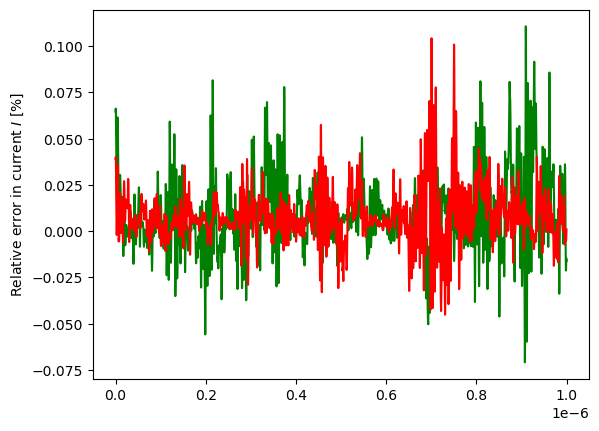

<Figure size 640x480 with 0 Axes>

In [255]:
color = ["r","g"]
plt.plot(times,(f*s1ap-s1)/s1, "-", color= "g")
plt.plot(times,(f*s0ap-s0)/s0, "-", color = "r")
plt.ylabel("Relative error in current $I$ [$\%$]")
plt.figure()

In [256]:
np.mean(np.abs((f*s1ap-s1)/s1))

0.015153037290854059

## Main, gathering statistics

In [247]:
#Parameters
Lc = 800*1e-9  #H
Cp = 0.6*1e-12 #F
Rc = 10*1e6    #Ohm
Rl = 20        #Ohm
w = 1/np.sqrt(Lc*Cp) #Hz

noise = OU_process(sig = 10, tc = 1e-7)
sd = sensor_dot(dmu = 4, gmax=1e-6, T=100, dE = 1e3)


N = 5000 #number of shots

def get_I(times, s):
    return np.sum(s)*(times[1]-times[0])



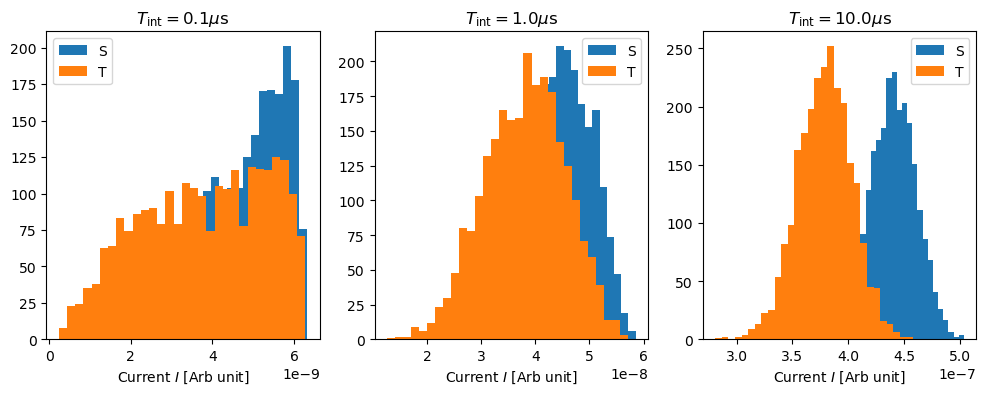

In [248]:


Tfs = [1e-7,1e-6,1e-5]
fig,ax = plt.subplots(1,3, figsize=(12,4))
for tn,Tf in enumerate(Tfs):
    Is = []
    bits =  []
    ax[tn].set_title(r"$T_\mathrm{int} = "+str(round(Tf*1e6,3))+"\mu$s")
    times = np.linspace(0,Tf,1001) #10us
    for n in range(N):
        bit = np.random.randint(0,2)
        i = RLC_solution(Lc, Cp, sd, times, noise, A=1, bit=bit)
        s = lowpass(modulate(i, w), 5000)
        Is.append(get_I(times, f*s))
        bits.append(bit)
    bits = np.array(bits)
    Is = np.array(Is)
    ax[tn].hist(Is[bits==0], bins = 30,  label="S")
    ax[tn].hist(Is[bits==1], bins = 30, label = "T")
    ax[tn].set_xlabel("Current $I$ [Arb unit]")
    ax[tn].legend()

